In [75]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
%matplotlib inline

import astropy.units as u
from astropy.constants import R_sun

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

%matplotlib inline
import time
metatstamp = time.strftime("%d_%m_%Y", time.localtime())


#rot period
from funcs.helper import fetch_lightcurve
from funcs.multiperiod import find_period
from scipy import optimize

def cosine(x, a, b, c, d, e,):
    """cosine with a linear trend"""
    return a * np.cos(b * x + c) + d * x + e



In [36]:
np.cos(np.pi)

-1.0

In [9]:
CWD = "/".join(os.getcwd().split("/")[:-2])
df = pd.read_csv(f"{CWD}/analysis/results/mcmc/06_11_2020_mcmcoutput.csv")
df = df.drop_duplicates(keep=False).fillna("")


In [10]:
df

,ED_s_16,ED_s_50,ED_s_84,Eflare_erg_16,Eflare_erg_50,Eflare_erg_84,ID,a_16,a_50,a_84,...,phase_deg_50,phase_deg_84,rad_rsun_16,rad_rsun_50,rad_rsun_84,suffix,t0_d_16,t0_d_50,t0_d_84,tstamp
0,2081.469776,2197.168028,2320.858458,2.705911e+33,2.856318e+33,3.017116e+33,452922110,0.299427,0.349941,0.403092,...,292.020911,298.794562,7.031695,7.604961,8.165761,,1493.931255,1493.931933,1493.932998,05_11_2020_10_05
1,11759.702738,13205.144981,16523.526694,1.324578e+34,1.487388e+34,1.861161e+34,277539431,0.933190,1.048971,1.303611,...,237.469690,242.966736,10.964467,11.633717,12.991225,,1641.840050,1641.841794,1641.844438,30_10_2020_11_30
2,4196.200730,4529.589956,4872.580560,3.722319e+34,4.018058e+34,4.322315e+34,237880881,2.164505,2.417842,2.649769,...,-211.032562,-207.487137,25.405954,26.964703,28.339256,a,1331.665664,1331.665958,1331.666311,06_11_2020_07_58
3,5123.261172,5294.041637,5576.879354,4.544686e+34,4.696180e+34,4.947076e+34,237880881,0.549931,0.583342,0.618394,...,-211.032562,-207.487137,12.489034,12.869139,13.256977,b,1331.828205,1331.828917,1331.829765,06_11_2020_07_58
4,2060.718843,2098.499984,2138.414298,1.918210e+33,1.953378e+33,1.990532e+33,44984200,0.586774,0.598251,0.609718,...,-41.343807,-40.365896,8.040800,8.119582,8.197559,a,1588.012729,1588.012974,1588.013217,02_11_2020_11_17
5,294.227489,332.316968,369.212252,2.738802e+32,3.093356e+32,3.436794e+32,44984200,0.047351,0.051291,0.055305,...,-41.343807,-40.365896,2.277274,2.370188,2.461223,b,1588.118296,1588.118754,1588.119398,02_11_2020_11_17


In [11]:
df.columns

Index(['ED_s_16', 'ED_s_50', 'ED_s_84', 'Eflare_erg_16', 'Eflare_erg_50',
       'Eflare_erg_84', 'ID', 'a_16', 'a_50', 'a_84', 'color', 'frac_area_16',
       'frac_area_50', 'frac_area_84', 'fwhm1_d_16', 'fwhm1_d_50',
       'fwhm1_d_84', 'fwhm2_d_16', 'fwhm2_d_50', 'fwhm2_d_84', 'i_deg_16',
       'i_deg_50', 'i_deg_84', 'latitude_deg_16', 'latitude_deg_50',
       'latitude_deg_84', 'linestyle', 'phase_deg_16', 'phase_deg_50',
       'phase_deg_84', 'rad_rsun_16', 'rad_rsun_50', 'rad_rsun_84', 'suffix',
       't0_d_16', 't0_d_50', 't0_d_84', 'tstamp'],
      dtype='object')

In [169]:
props.columns

Index(['ID', 'QCS', 'typ', 'cadence_min', 'mission', 'prefix', 'origin',
       'h_mission', 'SpT', 'view_start', 'view_stop', 'view_min', 'view_max',
       'BJDoff', 'tstart', 'ampl_min', 'ampl_max', 'GRP', 'plxmas', 'eplxmas',
       'RA', 'Dec', 'J', 'R', 'Gaia_G', 'vsini_kms', 'e_vsini_kms', 'Prot_d',
       'sini', 'Ref', 'identifier', 'Rstar', 'idtyp', 'id', 'st',
       'desig_2mass', 'dist', 'dist_err', 'dist_source', 'rad', 'rad_err',
       'tflux', 'tfluxerr', 'tlum', 'tlumerr', 'kflux', 'kfluxerr', 'klum',
       'klumerr', 'gmag', 'jmag', 'kmag', 'i_mu', 'i_sigma'],
      dtype='object')

In [170]:
sinusoidalres = {}
for i, row in df.iterrows():
    ID = row.ID
    tstamp = row.tstamp
    print(ID, tstamp)
    props = pd.read_csv(f"{CWD}/data/summary/lcsi.csv")
    target = props[props.ID == int(ID)].iloc[0]
    # Pick up the input parameters
    inits = pd.read_csv(f"{CWD}/data/summary/inits_decoupled.csv")
    inits = inits[(inits.ID.astype(str) == str(ID) + row.suffix) & (inits.tstamp==tstamp)].iloc[0]


    # Fetch light curve
    flck = fetch_lightcurve(target)

    # Get the dominant modulation period
    period, mfp = find_period(target, save=False, plot=False)

    # Optimize for the model parameters using
    # non-linear least-squares (Levenberg-Marquardt):
    cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux))
    p, p_cov = optimize.curve_fit(cosine, flck.time[cond],
                                  flck.flux[cond],
                                  p0=[(np.nanstd(flck.flux), 2 * np.pi * mfp.value,
                                      0, 0, np.nanmean(flck.flux),)],
                                  method="lm")
    model = cosine(flck.time, *p)
    # Calculate the relative amplitude of the oscillation
    rel_amplitude = p[0] / np.nanmedian(flck.flux)
    print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

#     plt.scatter(flck.time, np.log10(flck.flux),c="k",s=10,
#              label=(f"PDCSAP_FLUX"))#{target.prefix} {target.ID},"\
#                     #f" S{target.QCS}, {target.SpT}V"))
#     plt.plot(flck.time, np.log10(model),linewidth=3,
#                  c="orange",label=f"{period:.2f} rotation period")    
    rotmodphase = [((p[1] * t + p[2]) % (2 * np.pi)) / np.pi * 180. for t in [row.t0_d_16,row.t0_d_50,row.t0_d_84]]
    print(p, "\n", rotmodphase)
    sinusoidalres[str(ID)+row.suffix] = rotmodphase
    
    lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")
    
    df["timestart"] = lc.t[0]
    df["Prot_d"] = target.Prot_d

7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


452922110 05_11_2020_10_05
TIC 452922110 modulation period:  4.232851873935665 h
Relative amplitude of modulation: -5.8e-03
[-1.82610251e+00  3.56346258e+01 -1.39973369e+01  3.65122284e-03
  3.08029014e+02] 
 [177.86740909268715, 179.25100026481203, 181.42618562981986]
277539431 30_10_2020_11_30
TIC 277539431 modulation period:  4.556764823311947 h
Relative amplitude of modulation: 5.4e-03
[ 4.23320311e+00  3.30752837e+01  2.85623918e+01 -1.05034039e-01
  9.52266702e+02] 
 [125.16351994063123, 128.46722412500742, 133.47864626740335]
237880881 06_11_2020_07_58


10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
10% (1972/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 237880881 modulation period:  8.440140530163145 h
Relative amplitude of modulation: -1.3e-02
[-7.75192301e+00  1.78681079e+01 -1.55852265e+00  2.18150339e-02
  5.89294737e+02] 
 [266.289232293502, 266.58927199644677, 266.9513907288857]
237880881 06_11_2020_07_58
TIC 237880881 modulation period:  8.440140530163145 h
Relative amplitude of modulation: -1.3e-02
[-7.75192301e+00  1.78681079e+01 -1.55852265e+00  2.18150339e-02
  5.89294737e+02] 
 [72.69250544050867, 73.42154465010253, 74.28952386794761]
44984200 02_11_2020_11_17
TIC 44984200 modulation period:  2.7114843822240977 h
Relative amplitude of modulation: 4.9e-03
[ 8.25507467e+00  5.56007172e+01  2.17583380e+01 -2.49899814e+00
  5.64338931e+03] 
 [357.2690989521809, 358.0504457343785, 358.82367640505646]
44984200 02_11_2020_11_17
TIC 44984200 modulation period:  2.7114843822240977 h
Relative amplitude of modulation: 4.9e-03
[ 8.25507467e+00  5.56007172e+01  2.17583380e+01 -2.49899814e+00
  5.64338931e+03] 
 [333.57387127879895,

In [148]:
rmp = pd.DataFrame(sinusoidalres, index=["rotmod_16","rotmod_50","rotmod_84"]).T#{"rotmodphase":pd.Series(sinusoidalres)})

In [149]:
rmp

,rotmod_16,rotmod_50,rotmod_84
452922110,177.867409,179.251000,181.426186
277539431,125.163520,128.467224,133.478646
237880881a,266.289232,266.589272,266.951391
237880881b,72.692505,73.421545,74.289524
44984200a,357.269099,358.050446,358.823676
44984200b,333.573871,335.031806,337.084119


In [172]:
ddd = df[["ID","suffix","phase_deg_16","phase_deg_50","phase_deg_84","color",
          "timestart", "t0_d_16", "t0_d_50", "t0_d_84","Prot_d"]]

for i in ["16", "50", "84"]:
    
    dt = ddd[f"t0_d_{i}"]-ddd.timestart
    ddd[[f"phase_deg_{i}"]] = dt / ddd.Prot_d * 360 - ddd[f"t0_d_{i}"]

ddd['ID'] = ddd.ID.astype(str) + ddd.suffix
ddd.phase_deg_50 = (ddd.phase_deg_50 + 360) % 360




dd = ddd.drop_duplicates().set_index("ID").drop("suffix",axis=1)
dd = dd.join(rmp)

In [173]:
dd

,phase_deg_16,phase_deg_50,phase_deg_84,color,timestart,t0_d_16,t0_d_50,t0_d_84,Prot_d,rotmod_16,rotmod_50,rotmod_84
ID,,,,,,,,,,,,
452922110,-300545.140557,57.017687,-300539.589271,#377eb8,1587.800107,1493.931255,1493.931933,1493.932998,0.113,177.867409,179.251000,181.426186
277539431,170520.810624,246.362793,170534.784933,#ff7f00,1587.800107,1641.840050,1641.841794,1641.844438,0.113,125.163520,128.467224,133.478646
237880881a,-817335.199736,225.733659,-817333.139825,#f781bf,1587.800107,1331.665664,1331.665958,1331.666311,0.113,266.289232,266.589272,266.951391
237880881b,-816817.535237,24.732734,-816812.567067,#f781bf,1587.800107,1331.828205,1331.828917,1331.829765,0.113,72.692505,73.421545,74.289524
44984200a,-910.634436,170.146703,-909.080272,#4daf4a,1587.800107,1588.012729,1588.012974,1588.013217,0.113,357.269099,358.050446,358.823676
44984200b,-574.418945,147.038602,-570.909630,#4daf4a,1587.800107,1588.118296,1588.118754,1588.119398,0.113,333.573871,335.031806,337.084119


bright 452922110 0.3395369801289732
bright 277539431 0.32748769067665423
bright 237880881a 0.11348781449014489
bright 237880881b 0.1352466964780496
bright 44984200a 0.02195484125025815
bright 44984200b 0.02220334365087484
dark 452922110 0.33953698012897326
dark 277539431 0.17251230932334571
dark 237880881a 0.3865121855098551
dark 237880881b 0.13524669647804954
dark 44984200a 0.02195484125025826
dark 44984200b 0.022203343650875007


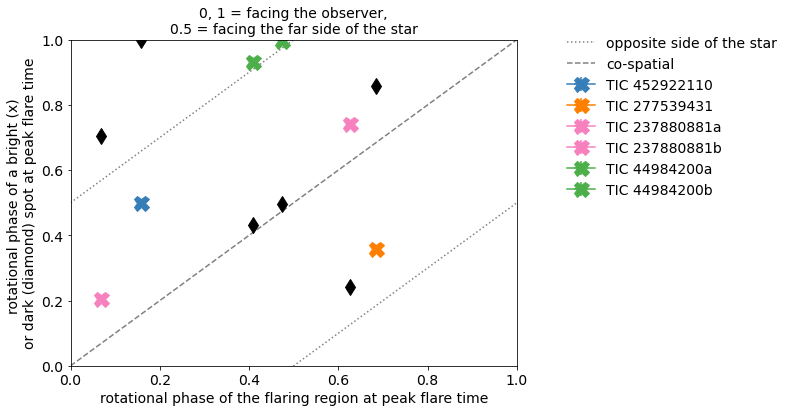

In [179]:
plt.figure(figsize=(8,6))

#bright spot
for lab, row in dd.iterrows():
    c = row.color
    row = row.drop("color")/360
    plt.errorbar(x=[row.phase_deg_50],
                 xerr=[[row.phase_deg_84-row.phase_deg_50],[row.phase_deg_50-row.phase_deg_16]],
                 y=[row.rotmod_50],
                 yerr=[[row.rotmod_84-row.rotmod_50],[row.rotmod_50-row.rotmod_16]],
                label=f"TIC {str(lab)}", markersize=15, marker="X",capsize=0,color=c)
    print(f"bright {lab}", np.abs(row.phase_deg_50-row.rotmod_50)%0.5)
    
# dark spot
for lab, row in dd.iterrows():
    c = row.color
    row = row.drop("color")/360
    plt.errorbar(x=[row.phase_deg_50],
                 xerr=[[row.phase_deg_84-row.phase_deg_50],[row.phase_deg_50-row.phase_deg_16]],
                 y=[(row.rotmod_50 +.5) %1],
                 yerr=[[row.rotmod_84-row.rotmod_50],[row.rotmod_50-row.rotmod_16]],
                 markersize=11, marker="d",capsize=0,color="k")    
    print(f"dark {lab}", np.abs(row.phase_deg_50-(row.rotmod_50+.5)%1)%0.5)
    
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[-.5,.5],c='grey', linestyle="dotted", label="opposite side of the star")
plt.plot([0,1],[0,1],c='grey', linestyle="dashed", label="co-spatial")
plt.plot([0,1],[0.5,1.5],c='grey', linestyle="dotted")
plt.xlabel("rotational phase of the flaring region at peak flare time", fontsize=14)
plt.ylabel("rotational phase of a bright (x) \nor dark (diamond) spot at peak flare time", fontsize=14)
plt.legend(frameon=False, fontsize=14, loc=(1.1,.5))
plt.title("0, 1 = facing the observer,\n0.5 = facing the far side of the star", fontsize=14)
plt.savefig(f"{CWD}/analysis/plots/{metatstamp}_flare_spot_longitudes.png", dpi=300);

Assuming a single bright or dark spot that is responsible for the rotational variability we can determine the longitudinal distance between the spot and the flaring region. There is no clear spatial correlation between either a bright or dark spot and the flaring region longitude.  

In [181]:
0.0002 * 360

0.07200000000000001